<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline, </h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
#from caiman.source_extraction import cnmf
#from caiman.utils.visualization import inspect_correlation_pnr
#from caiman.components_evaluation import estimate_components_quality_auto
#from caiman.base.rois import register_ROIs
import os
import cv2
#from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour,plot_contours_colorized


try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

Loading BokehJS ...

### (Re)start cluster.  

In [3]:
frate = 10 # movie frame rate
gSig = 3   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 10  # average diameter of a neuron

min_corr = .3 # min correlation of peak (from correlation image)
min_pnr = 5 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size


In [4]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=10,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

In [5]:
root1 = '/home/sebastian/Desktop/cnmfs/'
file1 = '32364_20170710_cnmf_rvm_15.pkl'


In [7]:
from caiman.source_extraction import cnmf
from caiman.utils.utils import load

cnm1= load()#cnmf.CNMF(n_processes=n_processes) 
cnm1.load(root1+file1)

AttributeError: 'CNMF' object has no attribute 'load'

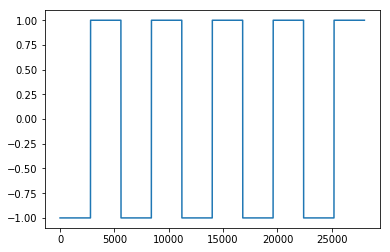

In [305]:

x_rest = -np.ones((28000,))
for i in range(1,10,2):
    x_rest[i*2800:(i+1)*2800]=1 

plt.plot(x_rest)

(95, 28000)


/home/sebastian/Documents/CaImAn/caiman/base/traces.py:127: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(colors)


[ 8 11 16 18 31 33 35 58 67 77 81 86 90]
[ 0 12 13 29 37 46 61 68 69 71 73 74 82 87 88 92 94]


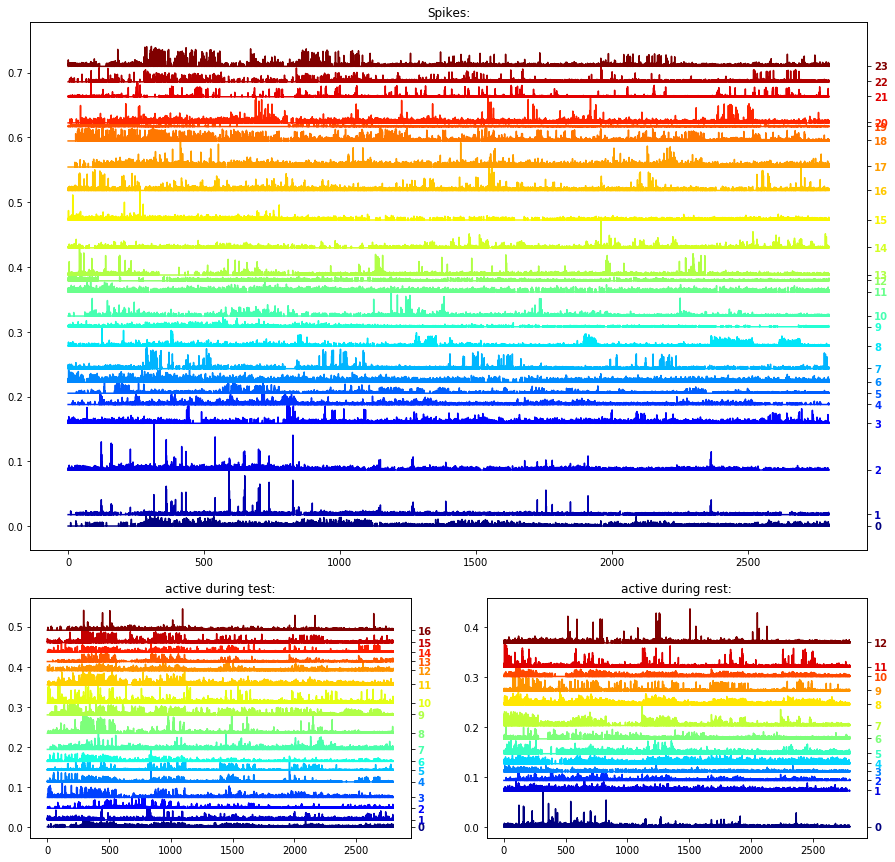

In [306]:
from caiman.base.traces import trace

spikes = cnm1.S
# spikes[spikes>spikes.std()*10]=spikes.std()*10
print(spikes.shape)
trains = np.zeros((spikes.shape[0]))

for i in range(trains.shape[0]):
    trains[i] = (spikes[i,:]*x_rest).mean()

trains = trains-trains.mean()

rest_active = np.where(trains>(trains.mean()+(1.*np.std(trains))))[0]
test_active = np.where(trains<(trains.mean()-(1.*np.std(trains))))[0]

plt.figure(1,figsize=(15, 15))

trc = trace(spikes[::4,0:].T,fr = 10)
plt.subplot2grid((3,2),(0,0),colspan=2,rowspan=2)
plt.title('Spikes:')
trc.plot()

plt.subplot2grid((3,2),(2,0))
plt.title('active during test:')
trc = trace(spikes[rest_active,0:].T,fr = 10)
trc.plot()


plt.subplot2grid((3,2),(2,1))
plt.title('active during rest:')
trc = trace(spikes[test_active,0:].T,fr = 10)
trc.plot()

print(test_active)
print(rest_active)


/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


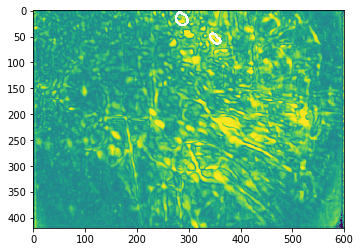

In [307]:
from caiman.utils.utils import eval_by_hand

# %matplotlib qt 
        
# accepted = eval_by_hand(cnm1)

crd = plot_contours(cnm1.A[:,accepted], cnm1.cn_filter, thr=.8, vmax=0.95,colors='w',display_numbers=0)



In [308]:
# plt.figure(1,figsize=(15, 7))


# # test_mat = spikes[test_active,0:]
# # rest_mat = spikes[rest_active,0:]
# # test_mat[test_mat>test_mat.std()*15]=test_mat.std()*15
# # rest_mat[rest_mat>rest_mat.std()*15]=rest_mat.std()*15


# plt.subplot(1,2,1)
# plt.title('active during test:')
# trc = trace(test_mat.T,fr = 10)
# plt.hold(True)
# # for x in range(0,2800,2*280):
# #     plt.axvspan(x,x+280,color=[0.9]*3)
# trc.plot()




# plt.subplot(1,2,2)
# plt.title('active during rest:')
# trc = trace(rest_mat.T,fr = 10)
# plt.hold(True)
# # for x in range(0,2800,2*280):
# #     plt.axvspan(x,x+280,color=[0.9]*3)
# trc.plot()


backend module://ipykernel.pylab.backend_inline version unknown
/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:941: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


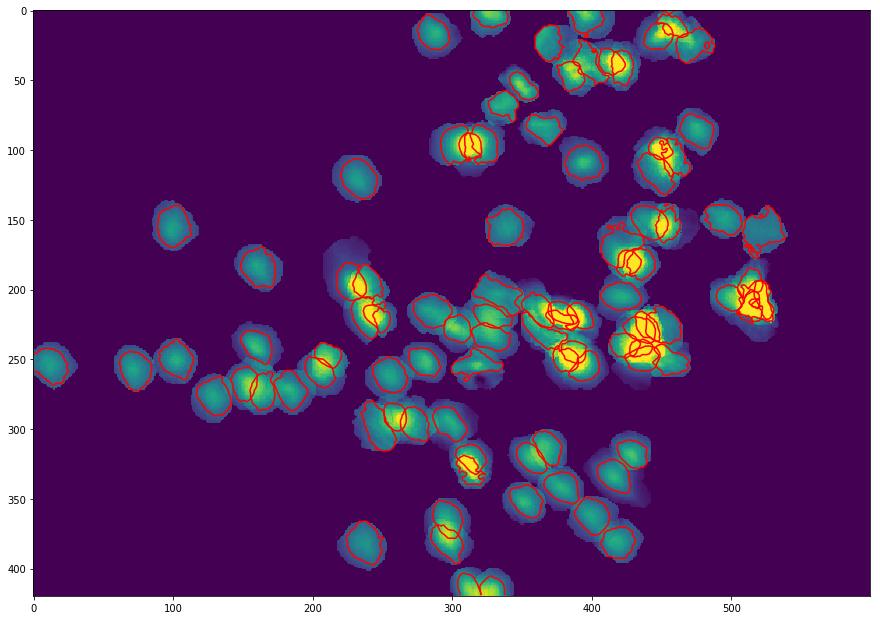

In [309]:
%matplotlib inline 

plt.figure(figsize=(15, 15))

A10=((cnm1.A.toarray()).reshape(list(cnm1.pnr.shape[::-1])+[cnm1.A.shape[-1]])[:,:,:].sum(2).T)
crd = plot_contours(cnm1.A[:,:], A10*10, thr=.8, vmax=0.95,colors='r',display_numbers=0)


### Statistical analysis:

Taking a look at the data, we can observe that the plots are dominated by few, very large spikes that seem to occur while the animals are transfered from their cage to the environment:

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'[n] cell')

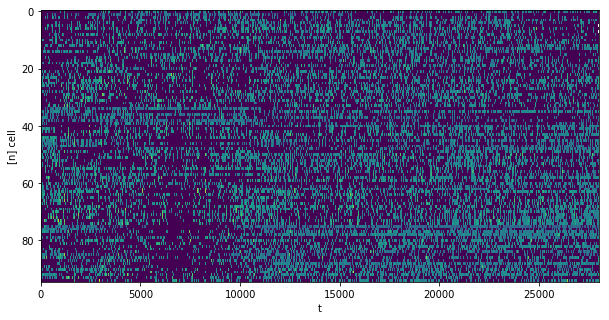

In [310]:
plt.figure(figsize=(10, 5))

plt.imshow(spikes**0.2,aspect='auto')

plt.xlabel('t')
plt.ylabel('[n] cell')

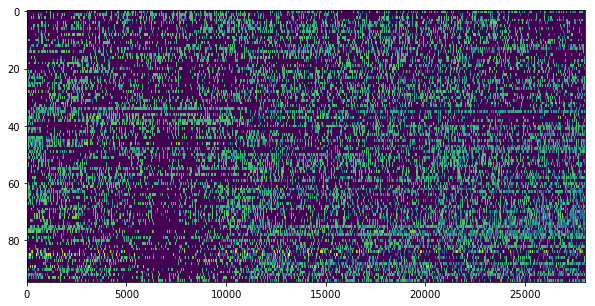

In [311]:
from scipy.ndimage.filters import gaussian_filter

spikes_norm = spikes.copy()
#spikes_norm =np.concatenate([spikes_norm,x_rest[np.newaxis,:]])

plt.figure(figsize=(10, 5))


for j in range(spikes_norm.shape[0]):
    spikes_norm[j,:][spikes_norm[j,:]>spikes_norm[j,:].std()]=spikes_norm[j,:].std()
    spikes_norm[j,:]/=spikes_norm[j,:].std()
    #spikes_norm[j,:]=gaussian_filter(spikes_norm[j,:],sigma=0.5)/spikes_norm[j,:].std()
    
plt.imshow(spikes_norm, aspect = 'auto')

explore spectrograms:

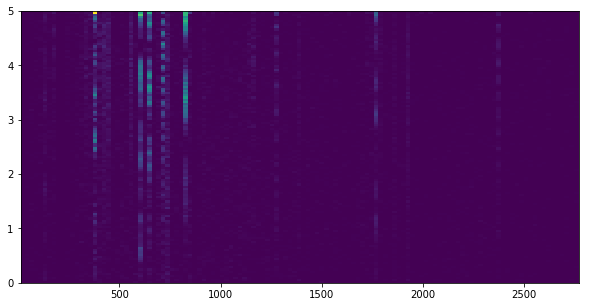

In [312]:
from  scipy.signal import spectrogram as spectrogram

plt.figure(figsize=(10, 5))
f, t, Sxx  = spectrogram(spikes[4,:], 10)

plt.pcolormesh(t, f, Sxx[::-1,])

Powers:

As a first exploratory attempt, we could just find correlations between the neurons:

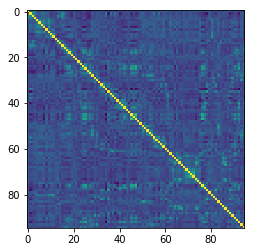

In [313]:
c_mat = np.corrcoef(spikes_norm)


plt.imshow(c_mat)


Correlate, sort, show cells according to test/rest activity:



Text(0.5,0,'t')

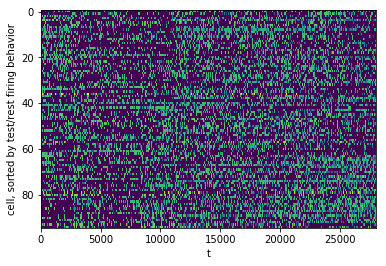

In [314]:
C = cnm1.C

for j in range(spikes_norm.shape[0]):
    C[j,:][C[j,:]>C[j,:].std()]=C[j,:].std()
    #C[j,:]=gaussian_filter(spikes_norm[j,:],sigma=1)/spikes_norm[j,:].std()
    

c_mat_active = np.corrcoef(np.concatenate([C,x_rest[np.newaxis,:]]))

idcs_rest = np.argsort(c_mat_active[-1,:-1])
plt.imshow(spikes_norm[idcs_rest,:],aspect='auto')
plt.ylabel('cell, sorted by test/rest firing behavior')
plt.xlabel('t')

backend module://ipykernel.pylab.backend_inline version unknown
/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:1072: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


<Figure size 1080x1080 with 0 Axes>

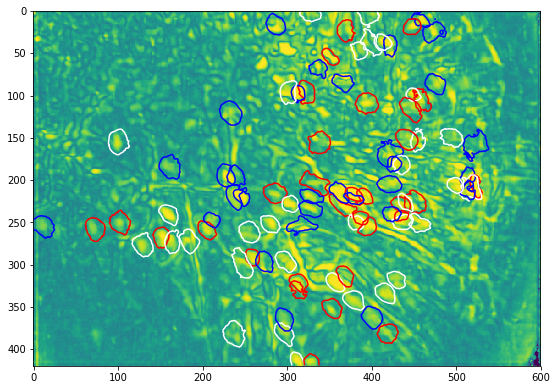

In [315]:
%matplotlib inline

from caiman.utils.visualization import plot_contours_colorized

plt.figure(figsize=(15,15))

one_third = idcs_rest.shape[0]//3

clrs = np.zeros((idcs_rest.shape[0],4),dtype = np.float)

clrs[idcs_rest[0:one_third],0]=1.0
clrs[idcs_rest[-one_third:],2]=1.0
clrs[idcs_rest[one_third:-one_third],:]=1.0
clrs[:,3]=1.0

plt.figure(2,figsize=(20, 20))
plt.subplot(1,2,1)
crd = plot_contours_colorized(cnm1.A[:,idcs_rest], cnm1.cn_filter, thr=.8, vmax=0.95,colors=clrs,display_numbers=0)
# pic = np.load('/home/sebastian/Desktop/cnmfs/32364_20170710_cn_filter.npy')
# plt.imshow(pic)
# plt.subplot(1,2,2)
# plt.imshow(cnm1.cn_filter)


In [316]:
help(cv2.drawContours)

Help on built-in function drawContours:

drawContours(...)
    drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]]) -> image



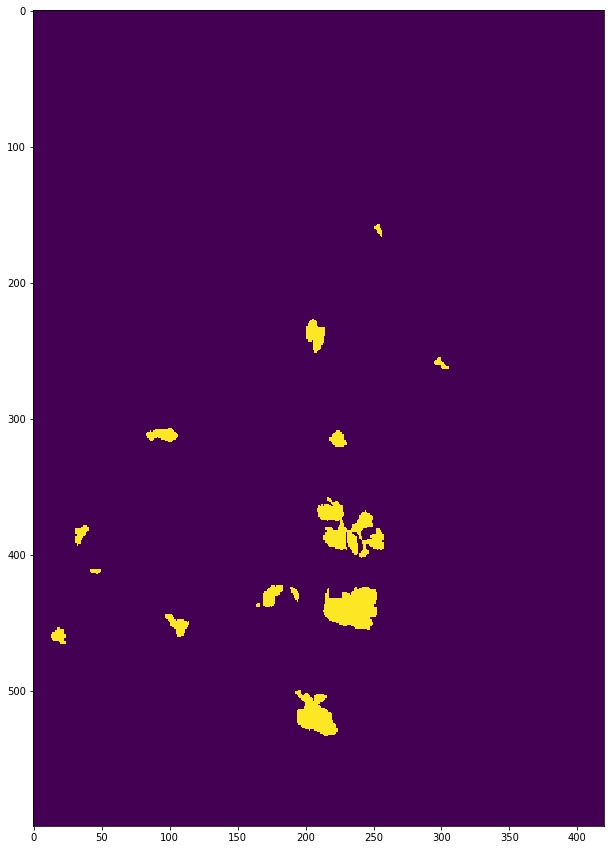

In [320]:
from caiman.utils.stats import get_ROI_distances
import cv2

cnm=cnm1
Arr = (cnm.A.toarray()).reshape(list(cnm.pnr.shape[::-1])+[cnm.A.shape[1]])
Arr1 = cnm.A.toarray()>0
clusters = Arr1.sum(1)>2

iscluster = np.dot(Arr1.T,clusters)

for i in range(Arr.shape[2]):
    Arr[:,:,i]=Arr[:,:,i]>0

plt.figure(figsize=(15,15))

# ret,thresh = cv2.threshold(img,127,255,0)
newshape=list(cnm1.cn_filter.shape[::-1])#+[1] 
clusters_reshaped = clusters.reshape(newshape).astype(np.uint8)
manip = cv2.erode(clusters_reshaped, kernel=(3,3))
manip = cv2.dilate(clusters_reshaped, kernel=(3,3))

im, contours, hierarchy = cv2.findContours(manip, 1, 2)
for n, cnt in enumerate(contours):
    cv2.drawContours(im, contours, n, n+1, cv2.FILLED)

plt.imshow(im!=0)
    
#A_clusters=np.zeros([len(contours)]+list(np.prod(im.shape)))

# A0 = Arr[:,:,0]
# A1 = Arr[:,:,1]
# A0/=A0.sum()
# A1/=A1.sum()


# X,Y = np.meshgrid(np.arange(A1.shape[1]),np.arange(A1.shape[0])) 
# cog = [(X*A0).sum(),(Y*A0).sum()]

# plt.imshow(A0+A1,interpolation='nearest')
# plt.hold(True)
# plt.scatter(cog[0],cog[1])
# print(Arr.shape)

# plt.figure(figsize=(15,15))
# dists,_ = get_ROI_distances(cnm)
# plt.subplot(1,3,1)
# plt.imshow(dists)
# plt.subplot(1,3,2)
# plt.imshow(c_mat)
# plt.subplot(1,3,3)
# dist_corr=np.nansum((c_mat/(1+dists))*(1-np.eye(c_mat.shape[0])),1) #(dists<20).sum(1)
# plt.plot(dist_corr)

# plt.figure(figsize=(10,10))


# dist_corr-=dist_corr.min()
# dist_corr=dist_corr/dist_corr.max()

# clrs = np.zeros((idcs_rest.shape[0],4),dtype = np.float)

# clrs[:,0]=0#dist_corr
# clrs[:,1]=1#-dist_corr
# clrs[:,2]=1#-dist_corr
# clrs[:,3]=iscluster

# crd = plot_contours_colorized(cnm1.A, cnm1.cn_filter, thr=.8, vmax=0.95,colors=clrs,display_numbers=0)

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


Text(518.151,0.218704,'2nd degree')

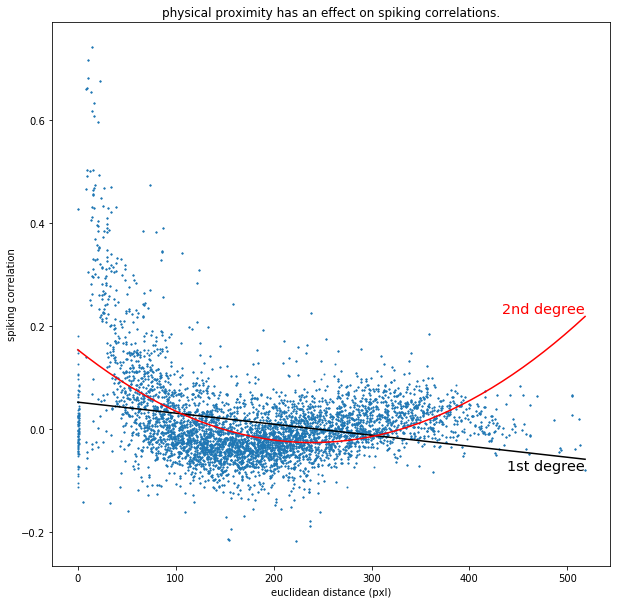

In [321]:
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour,plot_contours_colorized
from caiman.utils.stats import get_ROI_distances
from scipy.spatial import distance



cnmx = cnm1 #cnmf.CNMF(n_processes=n_processes)

clrs = np.ones((cnmx.S.shape[0],4),dtype = np.float)
dists,locs = get_ROI_distances(cnmx)

dists_0 = dists[:,0]
dists_0-=dists_0.min()
dists_0/=dists_0.max()

clrs[:,0] = dists_0
clrs[:,1] = dists_0
clrs[:,2] = dists_0
#crd = plot_contours_colorized(cnmx.A, cnmx.cn_filter, colors=clrs,color_text='r', thr=.8, vmax=0.95,display_numbers=0)

plt.figure(figsize=(10,10))

c_mat1 = np.corrcoef(spikes)

X = []
Y = []

for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        if i != j :
            X.append(dists[i,j])
            Y.append(c_mat1[i,j])

plt.hold(True)
plt.scatter(X,Y,1)
plt.xlabel('euclidean distance (pxl)')
plt.ylabel('spiking correlation')
plt.title('physical proximity has an effect on spiking correlations.')


##First degree polyfit:
x = np.linspace(0,np.max(X),50)

Ws = np.polyfit(X, Y,1)
y = (x)*Ws[0]+Ws[1]
plt.text(x[-1],y[-1],'1st degree',{'color':'k','ha':'right','size':'x-large','va':'top'})
plt.plot(x,y,'k')


##second degree polyfit:
Ws = np.polyfit(X, Y,2)
y = (x**2)*Ws[0]+(x)*Ws[1]+Ws[2]
plt.plot(x,y,'r')

plt.text(x[-1],y[-1],'2nd degree',{'color':'r','ha':'right','size':'x-large','va':'bottom'})




(95,)


/home/sebastian/Documents/CaImAn/caiman/base/traces.py:127: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(colors)


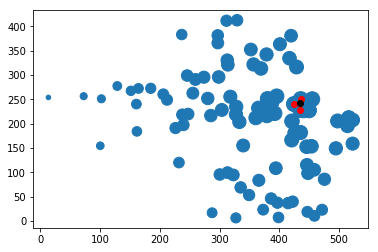

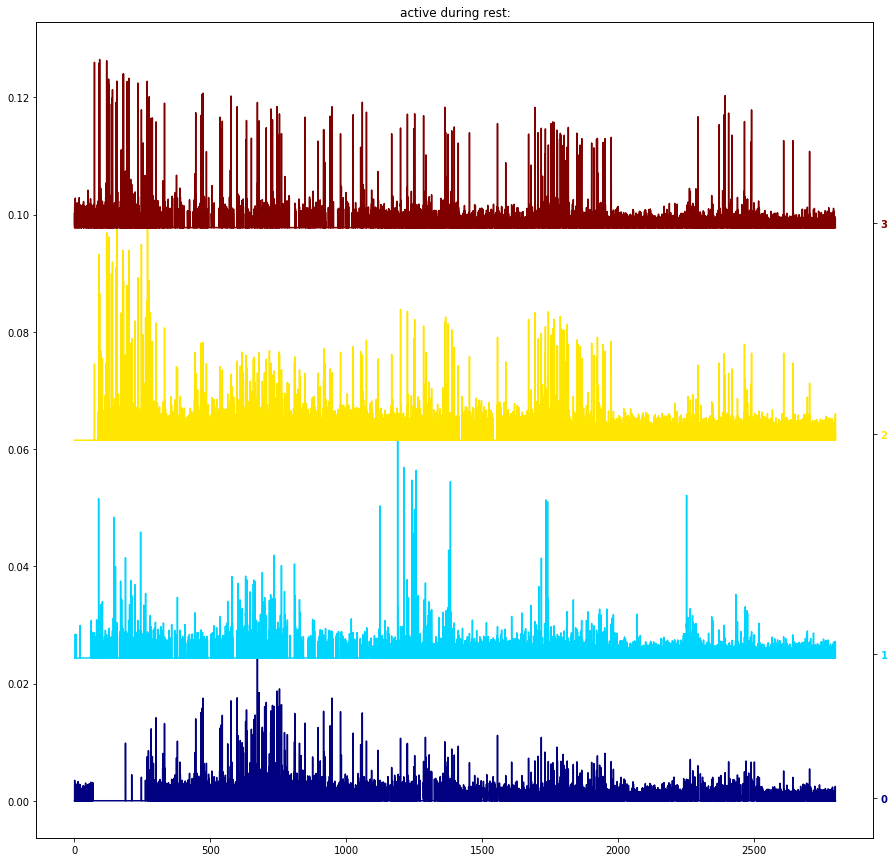

In [322]:
#plt.imshow(dists[:,:]<15,aspect='auto')
n = np.argsort((dists[:,:]<15).sum(1))[-1]
dists94=dists[:,n]
plt.scatter(locs[:,0],locs[:,1],( dists94.max()*1.1-dists94)/2)
plt.scatter(locs[dists94<15,0],locs[dists94<15,1],color = 'r')
plt.scatter(locs[n,0],locs[n,1],color = 'k')

print(dists94.shape)


plt.figure(figsize= (15,15))
plt.title('active during rest:')
trc = trace(cnm1.S[dists94<15,:].T,fr = 10)
trc.plot()

(95,) (95,)


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # Remove the CWD from sys.path while we load stuff.
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


Text(0,0.5,'activation')

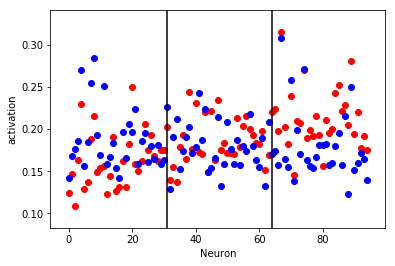

In [323]:

ppts = np.zeros((spikes.shape[0],2))

for i in range(ppts.shape[0]):
    ppts[i,0]=(spikes[idcs_rest[i],:]*x_rest>0).mean()
    ppts[i,1]=(spikes[idcs_rest[i],:]*x_rest<0).mean()

x=np.arange(spikes.shape[0])
print(x.shape,ppts[:,0].shape)
plt.hold(True)
plt.scatter(x,ppts[:,0],color='r')
plt.scatter(x,ppts[:,1],color='b')
plt.axvline(x=one_third,color='k')
plt.axvline(x=spikes.shape[0]-one_third,color='k')

plt.xlabel('Neuron')
plt.ylabel('activation')

(95,) (95,)


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


Text(0,0.5,'preference ratio')

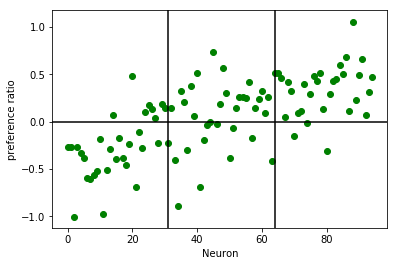

In [324]:
ppts = np.zeros((spikes.shape[0],2))

for i in range(ppts.shape[0]):
    ppts[i,0]=(spikes[idcs_rest[i],:]*x_rest>0).mean()
    ppts[i,1]=(spikes[idcs_rest[i],:]*x_rest<0).mean()

x=np.arange(spikes.shape[0])
print(x.shape,ppts[:,0].shape)
plt.hold(True)
# plt.scatter(x,ppts[:,0],color='r')
# plt.scatter(x,ppts[:,1],color='b')
plt.scatter(x,ppts[:,0]/ppts[:,1]-ppts[:,1]/ppts[:,0],color='g')

plt.axvline(x=one_third,color='k')

plt.axvline(x=spikes.shape[0]-one_third,color='k')
plt.axhline(y=0,color='k')

plt.xlabel('Neuron')
plt.ylabel('preference ratio')


<BarContainer object of 3 artists>

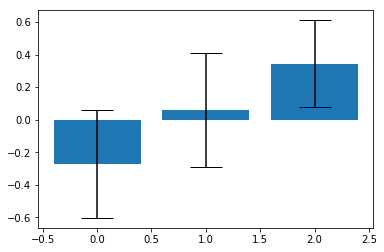

In [325]:
#print ('Hello world')

means = ppts[:,0]/ppts[:,1]-ppts[:,1]/ppts[:,0]

ppt_means = [means[0:one_third].mean(),means[one_third:-one_third].mean(),means[-one_third:].mean()]
stds = [means[0:one_third].std(),means[one_third:-one_third].std(),means[-one_third:].std()]

plt.bar([0,1,2],ppt_means,yerr=stds,capsize=16)

##SOM expolrations:

In [326]:
from sompy.sompy import SOMFactory

### Do a PCA:

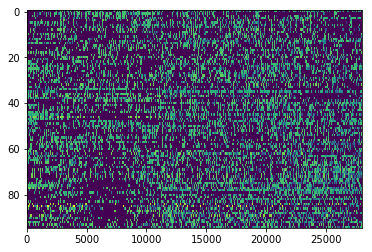

In [327]:
from sklearn import decomposition

spikes_ltd =  spikes.copy()
spikes_ltd[spikes>(spikes.std()*10)]=(spikes.std()*10)

plt.imshow(spikes_norm,aspect='auto')
pca = decomposition.PCA()
X =pca.fit_transform((spikes_norm).T)

params = pca.get_params()


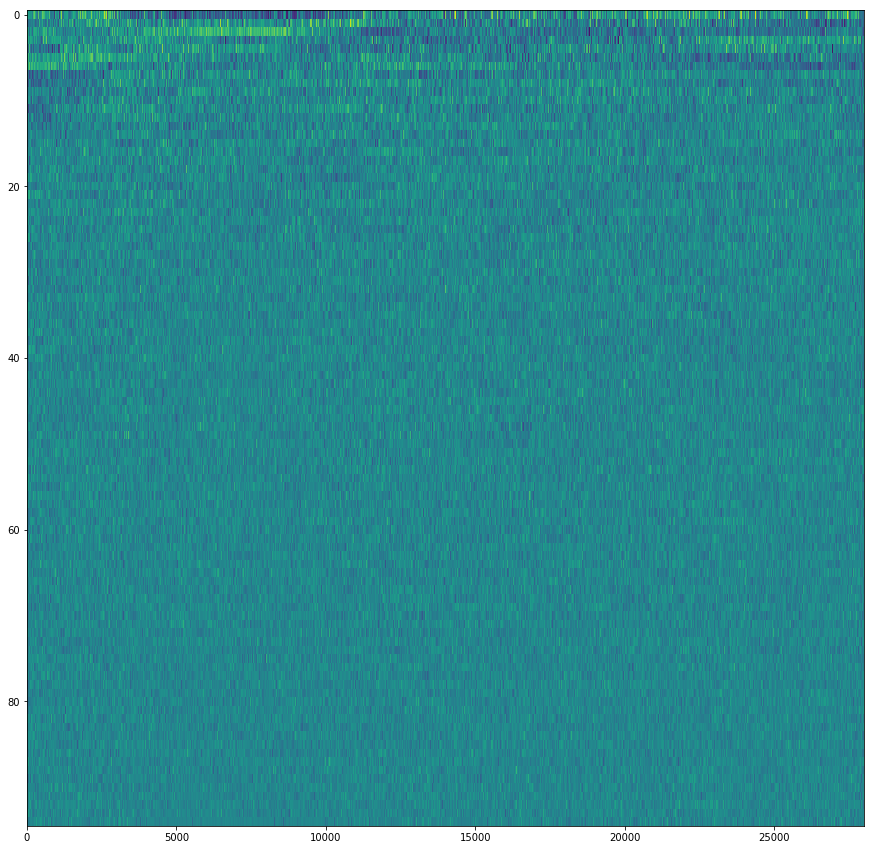

In [328]:
plt.figure(figsize=(15,15))
X.shape
plt.imshow(X.T,aspect='auto')

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/sebastian/Documents/CaImAn/caiman/utils/visualization.py:1072: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition fo

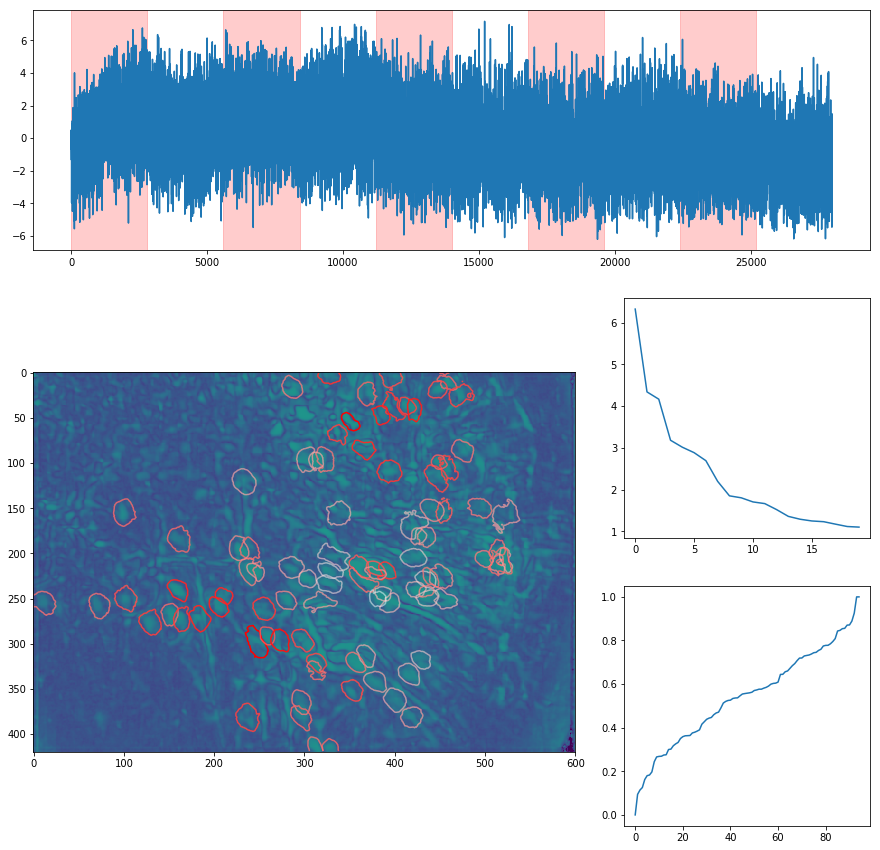

In [340]:
n_comp = 1
comp = pca.components_[n_comp,:]

comp = comp-comp.min()
comp/=comp.max()

plt.figure(figsize=(15,15))


plt.subplot2grid((3,3),(0,0),colspan=3,rowspan=1)

plt.hold(True)    

for i in range(0,28000,2*2800):
    plt.axvspan(i, i+2800,alpha=0.2, color='red')
    
plt.plot(X[:,n_comp])


plt.subplot2grid((3,3),(1,0),colspan=2,rowspan=2)

clrs = np.zeros((idcs_rest.shape[0],4),dtype = np.float)

clrs[:,0]=1
clrs[:,1]=1-comp
clrs[:,2]=1-comp
clrs[:,3]=0.5+(comp/2)


crd = plot_contours_colorized(cnm1.A, cnm1.cn_filter/2, thr=.8, vmax=0.95,colors=clrs,display_numbers=0)

plt.subplot2grid((3,3),(1,2),colspan=1,rowspan=1)

plt.plot(pca.explained_variance_[:20])#bar(np.arange(comp.shape[0]),comp)

plt.subplot2grid((3,3),(2,2),colspan=1,rowspan=1)

plt.plot(comp[comp.argsort()])#bar(np.arange(comp.shape[0]),comp)


(28000, 95)


/home/sebastian/Documents/CaImAn/caiman/base/traces.py:127: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(colors)


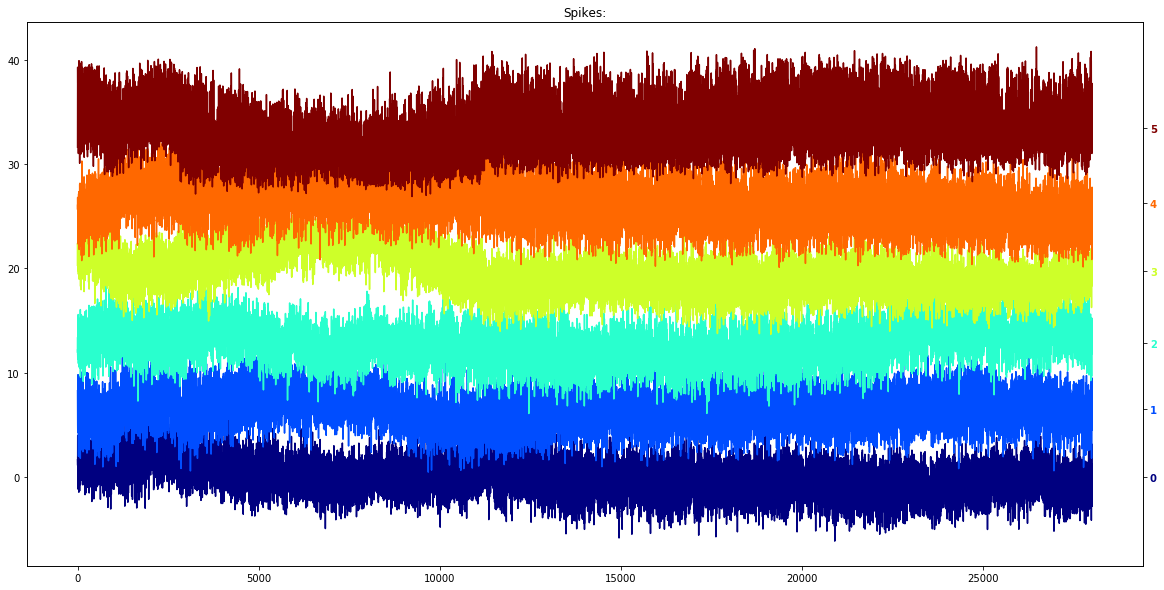

In [330]:

plt.figure(1,figsize=(20, 10))

# plt.hold(True)
# plt.plot(X[:,2])

# for i in range(0,28000,2800):
#     plt.axvline(x=i,color='r')
    
from caiman.base.traces import trace

spikes = cnm1.S[:,:]
print(X.shape)

plt.figure(1,figsize=(15, 15))

trc = trace(X[:,5::-1],fr = 1)
plt.title('Spikes:')
trc.plot()


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


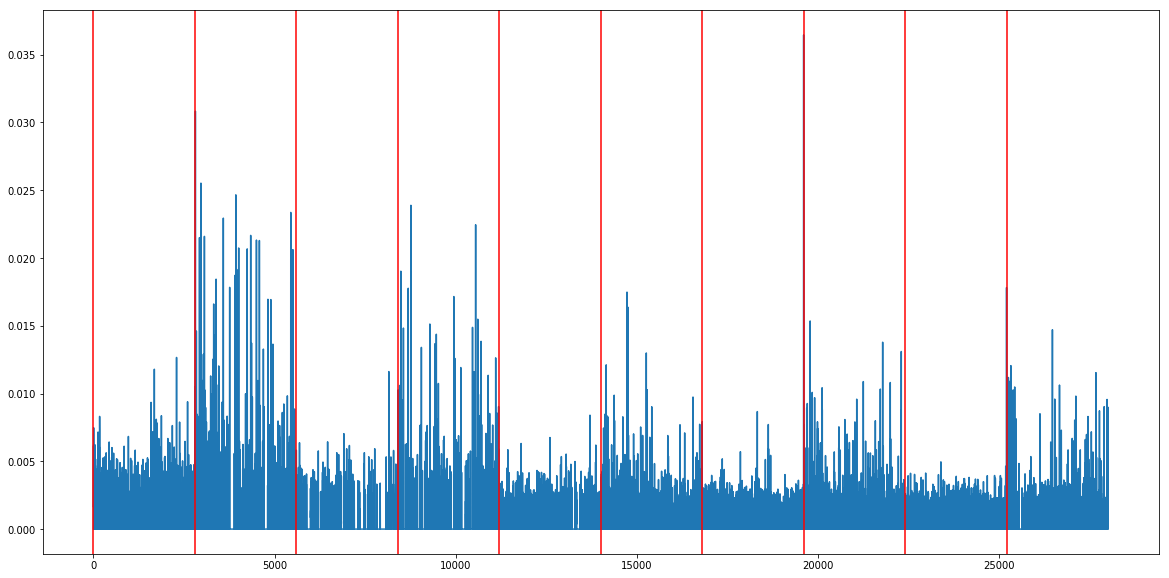

In [331]:
ids=(np.argsort(pca.components_[0,:]))[-2]

plt.figure(1,figsize=(20, 10))

plt.hold(True)
plt.plot(cnm1.S[ids,:])
for i in range(0,28000,2800):
    plt.axvline(x=i,color='r')


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  import sys
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


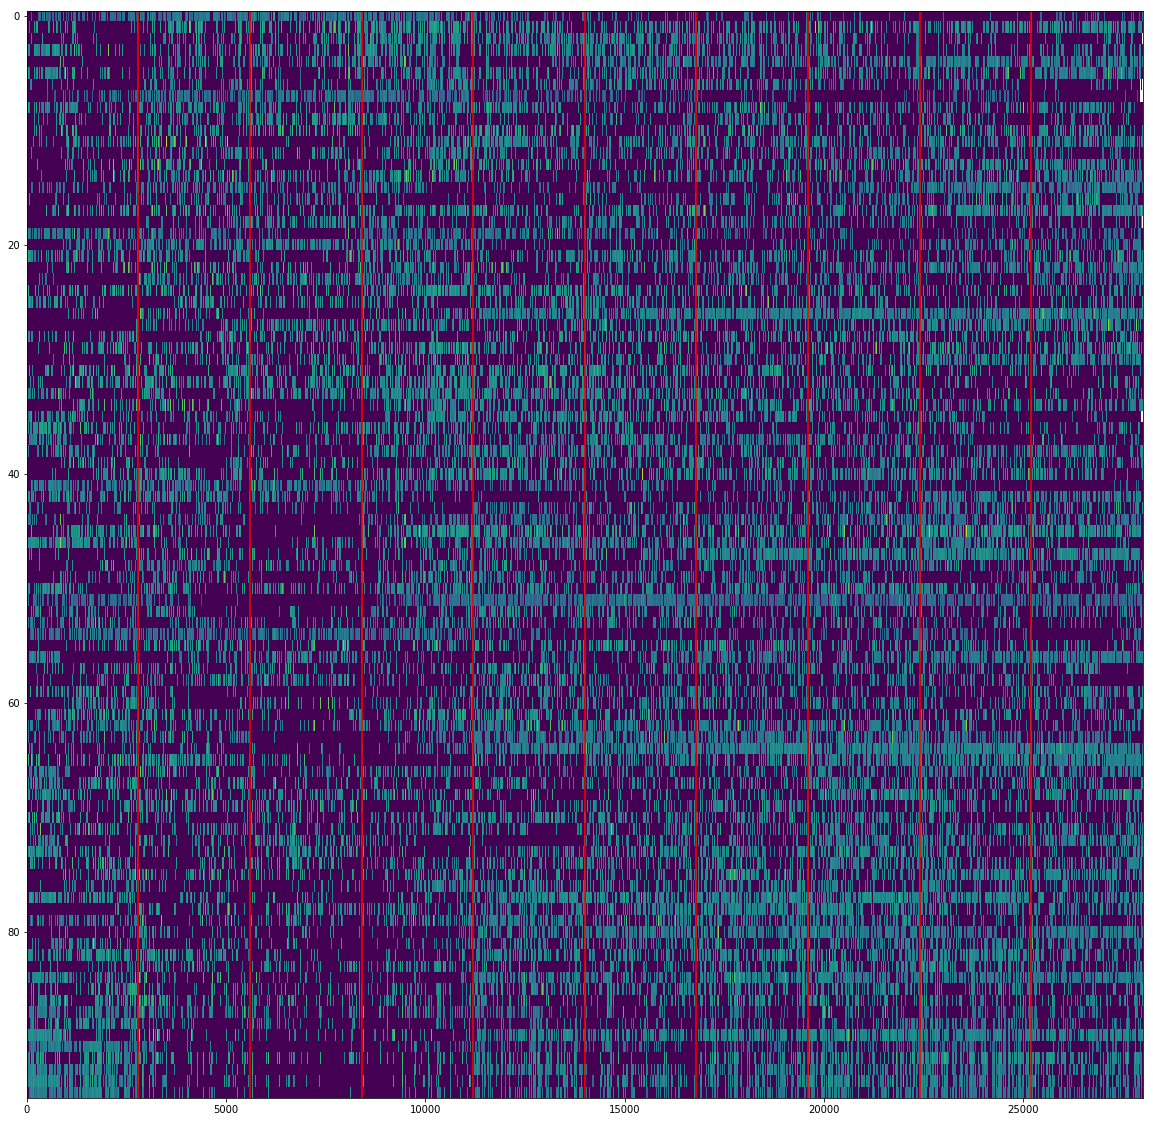

In [332]:
ids=(np.argsort(pca.components_[0,:]))

plt.figure(1,figsize=(20, 20))



plt.hold(True)
plt.imshow(cnm1.S[ids,:]**0.2,aspect='auto')
for i in range(0,28000,2800):
    plt.axvline(x=i,color='r')


In [333]:
# plt.figure(1,figsize=(20, 20))


# for n in range(4):
#     plcs = np.argsort(X[:,n])
#     print(plcs[-5:])
#     #plcs = np.argsort(c_mat[-1,:])
#     plt.subplot(2,2,n+1)
#     plt.title('principal component '+str(n+1)+':')

    
#     plt.imshow(spikes_norm[plcs,:],aspect='auto')

# # [115 106 145 138  99]
# # [110  98  24 104 100]
# # [112  87 122  95 170]
# # [166 106 183 194 117]
# # [ 40 111  60  56 178]
# # [ 51 204 214 115  98]
# # [168  11 106  98 139]
# # [107  55 179 129  50]
# # [142  91  85  74 141]


In [334]:
pca.score(X)

-160.01319867957204

### Behavioral analysis

In [33]:
be_root = '/home/sebastian/Desktop/behavioral/32364/20170711/'
be_names = sorted([f for f in os.listdir(be_root) if '.pkl' in f])#'32364_20170713_'

dicts = [pickle.load(open(be_root+name,'br')) for name in be_names]

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


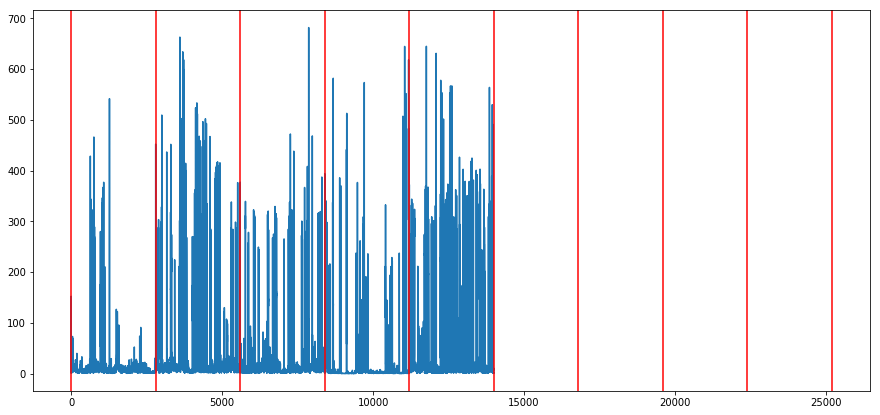

In [34]:
plt.figure(figsize=(15,7))

def find_px_diff(i):
    px_diff = dicts[i]['px_diff'] #np.concatenate([[0],(np.diff(dicts[i]['head_x'])**2+np.diff(dicts[i]['head_y'])**2)**0.5]) 
    if px_diff.shape[0]>5600:
        px_diff = velo[400:6000]
    if px_diff.shape[0]<5600:
        px_diff = np.abs(np.random.normal(0,velo.std(),(5600,)))
    px_diff = px_diff.reshape([2,-1]).sum(0)
    return px_diff
    
px_diff = [find_px_diff(i) for i in range(len(dicts))]


def find_velo(i):
    velo = np.concatenate([[0],(np.diff(dicts[i]['head_x'])**2+np.diff(dicts[i]['head_y'])**2)**0.5]) 
    if velo.shape[0]>5600:
        velo = velo[400:6000]
    if velo.shape[0]<5600:
        velo = np.abs(np.random.normal(0,velo.std(),(5600,)))
    velo = velo.reshape([2,-1]).sum(0)
    return velo
    
head_mvmts = [find_velo(i) for i in range(len(dicts))]


rest_mvmts = (np.concatenate(head_mvmts[1::2]))
test_mvmts = (np.concatenate(head_mvmts[::2]))

# head_mvmts_norm = []

# for i,e in enumerate(head_mvmts):
#     if i%2:
#         normed = px_diff[i]/px_diff[i].max()*100
#         #normed = normed/(rest_mvmts.max()-rest_mvmts.min())
#     else:
#         normed = e#-test_mvmts.min()
#         #normed = normed/(test_mvmts.max()-test_mvmts.min())

#     head_mvmts_norm.append(normed.copy())

# head_mvmts_norm_arr = np.concatenate(head_mvmts_norm)
plt.plot(test_mvmts)
plt.hold(True)
for i in range(0,28000,2800):
    plt.axvline(x=i,color='r')


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes 

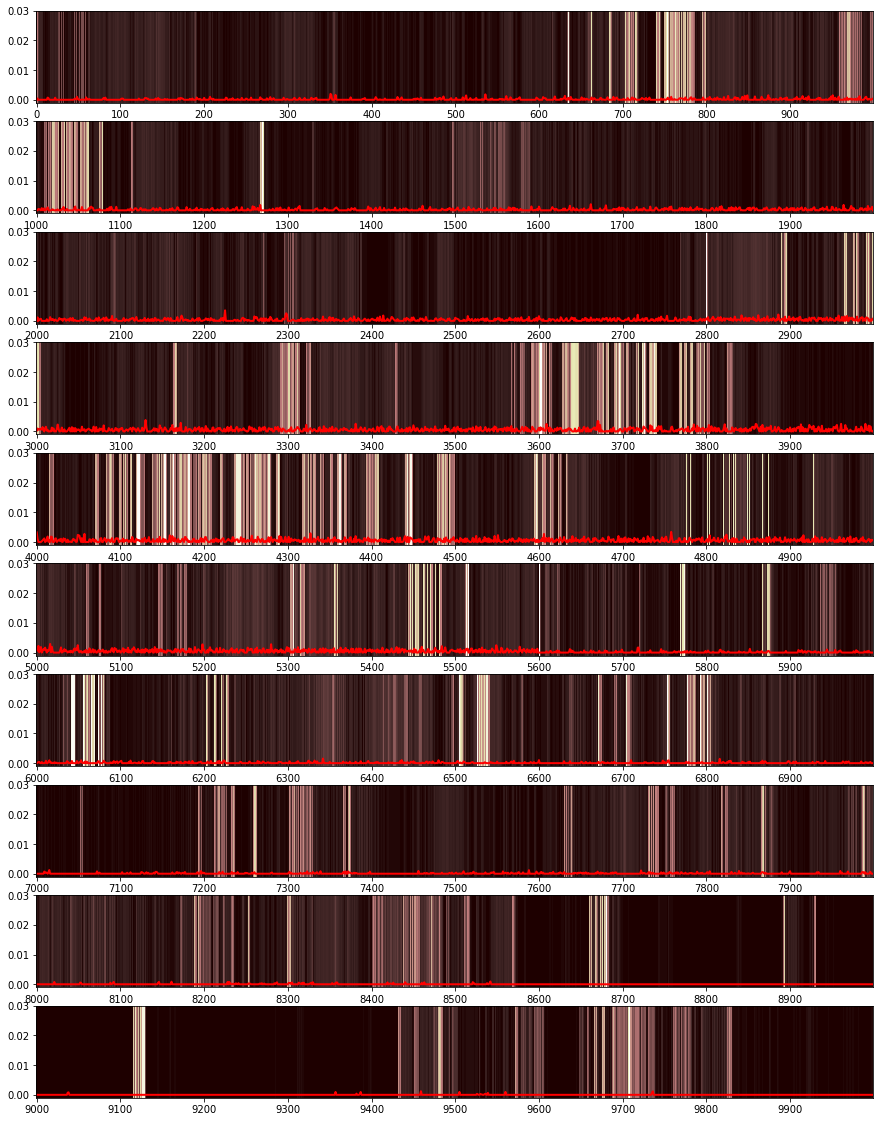

In [35]:
plt.figure(figsize=(15,20))

spikes_active = cnm1.S[:,x_rest<1]

corrs = (np.corrcoef(np.concatenate([cnm1.S[:,x_rest<1],[test_mvmts]]))[-1,0:-1])
#plt.imshow(cnm1.S[:,x_rest<1][np.argsort(corrs),:]**0.2,aspect='auto')

n_plots = 10

locs = np.random.randint(0,spikes_active.shape[1],size=(n_plots,))
length=1000
for i in range(n_plots):
    plt.subplot(n_plots,1,i+1)
    plt.hold(True)
    loc=i*length
    plt.imshow([test_mvmts[loc:loc+length]/test_mvmts.max()*spikes_active.max()],aspect='auto',cmap='pink')
    plt.plot(spikes_active[np.argsort(corrs)[-1],loc:loc+length].T,lw=2,color='r')
    plt.xticks(np.arange(0,length,length//10),np.arange(0,length,length//10)+loc)
    plt.ylim([-0.001,0.03])
    plt.hold(False)

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


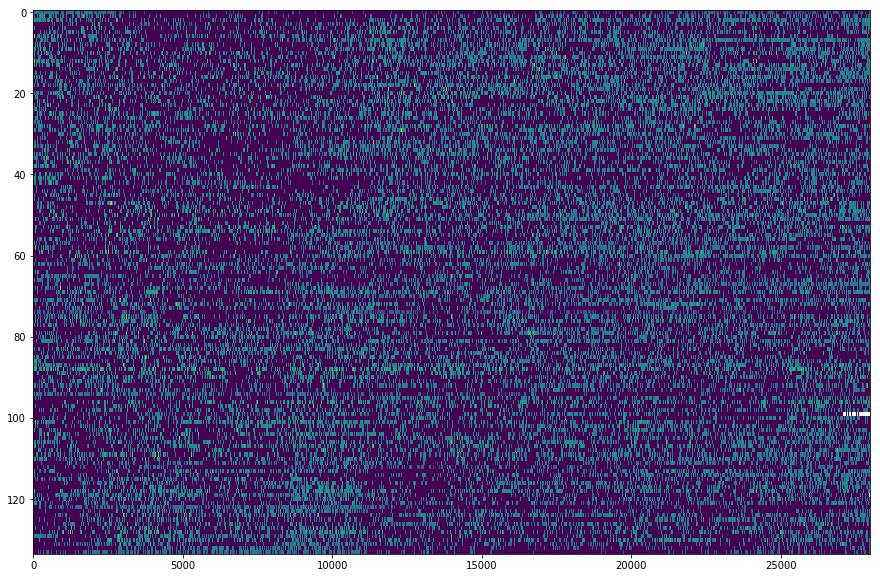

In [36]:
plt.figure(figsize=(15,10))


corrs = (np.corrcoef(np.concatenate([cnm1.S,[np.concatenate(head_mvmts)]]))[-1,0:-1])
plt.imshow(cnm1.S[np.argsort(corrs),:]**0.2,aspect='auto')

### Pairwise correlations:

according to Yuste&al

In [37]:
# Functions to calculate normalized correlation:

def calc_corr(spike_train_1,spike_train_2):
    return(np.inner(spike_train_1,spike_train_2)/((np.linalg.norm(spike_train_1)+np.linalg.norm(spike_train_2))/2))

def calc_corr_mat(spikes=spikes):
    corrmat = np.zeros([spikes.shape[0]]*2)
    for i in range(spikes.shape[0]):
        for j in range(spikes.shape[0]):
            corrmat[i,j]=calc_corr(spikes[i,:],spikes[j,:])
    return(corrmat)



In [38]:
# Bootstrapping: draw 10000 random samples from shifted firing patters

n_samples = 100

spikes_shifted=spikes.copy()
rnd_corrs = np.zeros([n_samples]+[spikes.shape[0]]*2)

for i in range(n_samples):
    print(i)
    for j in range(spikes.shape[0]):
        spikes_shifted[j,:]=np.roll(spikes_shifted[j,:],np.random.randint(spikes_shifted[j,:].shape[0]))
    
    rnd_corrs[i,:,:]=calc_corr_mat(spikes_shifted)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


KeyboardInterrupt: 

In [ ]:
corrmat = calc_corr_mat(spikes)

In [ ]:
clusters = (rnd_corrs.mean(0)+3*rnd_corrs.std(0))<corrmat
plt.imshow(clusters)


In [ ]:
plt.figure(2,figsize=(15, 20))

plot_cells = [0,10,20,30,40,50,60,70,80]

for i in range(9):    
    clrs = np.zeros((idcs_rest.shape[0],4),dtype = np.float)
    cluster = clusters[plot_cells[i],:]
    clrs[cluster,3]=1
    clrs[cluster,0]=1
    clrs[i,:]=[0,0,1,1]
    plt.subplot(9,3,i+1)
    crd = plot_contours_colorized(cnm1.A[:,cluster], cnm1.cn_filter, thr=.8, vmax=0.95,colors=clrs,display_numbers=0)


In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.imshow(rnd_corrs.mean(0))
plt.text(30,10,'random bootstrap (mean)',fontsize=20,color='w')

plt.subplot(2,2,2)
plt.imshow(rnd_corrs.std(0)*3)
plt.text(30,10,'random bootstrap (std)',fontsize=20,color='w')

plt.subplot(2,2,3)
plt.imshow(corrmat)
plt.text(30,10,'spiking correlations',fontsize=20,color='w')

plt.subplot(2,2,4)
plt.imshow(corrmat)
clusters = (rnd_corrs.mean(0)+3*rnd_corrs.std(0))<corrmat
plt.imshow(clusters,cmap='Greys')
plt.title('significant correlations',fontsize=25,color='g',weight='heavy')


### Compare active periods over 1 day:

In [ ]:
aps = []

n=0
for i,p in enumerate(frames1):
    aps.append(spikes[:,n:n+p])
    n+=p
    
actives = aps[::2]
pasives = aps[1::2]

In [ ]:
from caiman.utils.stats import norm_corr_mat

corrs = []

for a in actives:
    corrs.append(norm_corr_mat(a))

In [ ]:
plt.figure(figsize=(15,10))

for i,c in enumerate(corrs):
    plt.subplot(2,3,i+1)
    plt.imshow(c,vmin=0, vmax=0.2,cmap='inferno')
   

In [ ]:
from caiman.utils.stats import yuste_bootstrap

boots = []

for i,a in enumerate(actives):
    boots.append(yuste_bootstrap(a,1000))

plt.figure(figsize=(15,10))

for i,b in enumerate(boots):
    plt.subplot(2,3,i+1)
    plt.imshow(b.mean(0),vmin=0, vmax=0.2,cmap='inferno')
   

In [ ]:
sigs = []

plt.figure(figsize=(15,10))


for i,c in enumerate(corrs):
    sigs.append(c>(boots[i].mean(0)+boots[i].std(0)*3))
    
for i,s in enumerate(sigs):
    plt.subplot(2,3,i+1)
    plt.imshow(s,cmap='inferno')    

In [ ]:
sigmat = np.concatenate([sigs]).astype(np.float)
linsig = np.zeros(sigs[0].shape)
linsig1 = np.zeros(sigs[0].shape)

for i in range(sigmat.shape[1]):
    for j in range(sigmat.shape[2]):
        x = sigmat[:,i,j]
        y= np.arange(sigmat.shape[0])
        linsig[i,j],linsig1[i,j] = np.polyfit(y, x,1)
        

In [ ]:
significant_increase = (linsig>linsig.mean()+3*linsig.std()).astype(np.float)

plt.figure(2,figsize=(15, 5))

plt.subplot(1,2,1)
plt.imshow(linsig)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(significant_increase)
(linsig*significant_increase).mean()

In [ ]:
print(((linsig>-linsig.std())*(linsig<linsig.std())).sum()/np.product(linsig.shape))
print(((linsig>linsig.std())).sum()/np.product(linsig.shape))
print(((linsig<-linsig.std())).sum()/np.product(linsig.shape))

In [ ]:
linsig.std()

In [ ]:
cluster_ids = np.where(significant_increase.sum(1)>5)[0]

In [ ]:
#plt.figure(2,figsize=(15, 10))

for i in range(9):
    cell = cluster_ids[i]
    clrs = np.zeros((linsig.shape[0],4),dtype = np.float)
    cluster = linsig[cell,:].astype(np.float)
    alphas = cluster - cluster.min()
    alphas /= alphas.max()
    clrs[:,:]=1
    clrs[:,3]=alphas
    clrs[cell,:]=[1,0,0,1]
    plt.subplot(3,3,i+1)
    crd = plot_contours_colorized(cnm1.A, cnm1.cn_filter, thr=.8, vmax=0.95,colors=clrs,display_numbers=0)
    break


In [ ]:
def check_stable(linsig): return (((linsig>-linsig.std())*(linsig<linsig.std())).sum()/np.product(linsig.shape))
def check_increase(linsig): return (((linsig>linsig.std())).sum()/np.product(linsig.shape))
def check_decrease(linsig): return (((linsig<-linsig.std())).sum()/np.product(linsig.shape)) 

### Calculate same increase/decrease measure over whole week:

In [ ]:
results = []

for i,r in enumerate(roots):
    spikes=cnmfs[r].S



In [ ]:
map_name1 = '32364_20170710_cropped_rig__d1_420_d2_600_d3_1_order_F_frames_31519_.mmap'
Yr1, dims1, T1 = cm.load_memmap(root1+map_name1)
Y1 = Yr1.T.reshape((T1,) + dims1, order='F')

gSig=3


In [ ]:
np.shape(cnm1.A)
cnm1.compute_residuals(Yr1)




In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier


r_values_min = 0.5  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)
decay_time = 0.1  #decay time of transients/indocator

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y1, cnm1.A, cnm1.C, cnm1.b, cnm1.f, cnm1.YrA, frate, 
                            decay_time, [gSig]*2, cnm1.dims, dview = dview, 
                            min_SNR=min_SNR, r_values_min = r_values_min, min_std_reject = 0.5, use_cnn = True)

print(' ***** ')
print((len(cnm1.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

In [ ]:
plt.figure(2,figsize=(20, 20))
plt.subplot(2,1,1)
crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,idx_components], cnm1.cn_filter, thr=.8, vmax=0.95)


plt.subplot(2,1,2)
crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,idx_components_bad], cnm1.cn_filter, thr=.8, vmax=0.95)


In [ ]:
plt.figure(2,figsize=(20, 20))

crd = cm.utils.visualization.plot_contours(cnm1.A.tocsc()[:,:], cnm1.cn_filter, thr=.8, vmax=0.95)


### Load second CNMF object - let's have some fun! :D
plot contours of identified components against correlation image

In [ ]:
cnm2 = cnmf.CNMF(16)

path_cnmf_2 = "/home/sebastian/Desktop/dumped_files/20170711/cnmf_32364_20170711.pkl"

cnm2.load(path_cnmf_2)

plt.figure(figsize=(20, 15))

crd = cm.utils.visualization.plot_contours(cnm2.A, cnm2.cn_filter, thr=.8, vmax=0.95)


In [ ]:
matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance = register_ROIs(cnm1.A,cnm2.A,cnm1.dims,cnm1.cn_filter,cnm2.cn_filter)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(2,figsize=(20, 15))

plt.subplot(1,2,1)
crd3 = cm.utils.visualization.plot_contours(cnm1.A[:,matched_ROIs1], cnm1.cn_filter, thr=.9, vmax=0.95)
plt.subplot(1,2,2)
crd4 = cm.utils.visualization.plot_contours(cnm2.A[:,matched_ROIs2], cnm2.cn_filter, thr=.9, vmax=0.95)

In [ ]:
%matplotlib qt

spikes1 = cnm1.S[matched_ROIs1[::2],:]
spikes2 = cnm2.S[matched_ROIs2[::2],:]

trc1 = trace(spikes1.T)
trc2 = trace(spikes2.T)

plt.figure(3,figsize=(20, 20))


plt.subplot(1,2,1)
plt.title('spikes day 1:')
trc1.plot(cmap = plt.cm.tab20b)


plt.subplot(1,2,2)
plt.title('spikes day 2:')
trc2.plot(cmap = plt.cm.tab20b)


In [ ]:
cnm1.S[0].shape

### Stop cluster

In [ ]:
#%%
cm.stop_server(dview=dview)

In [ ]:
map_name1 = '/home/sebastian/Desktop/32366_20170717_cropped_rig__d1_420_d2_600_d3_1_order_F_frames_32870_.mmap'
Yr1, dims1, T1 = cm.load_memmap(map_name1)
Y1 = Yr1.T.reshape((T1,) + dims1, order='F')


In [ ]:
mov = cm.movie(Y1)
mov.play()